# Fingerprinting Presidential Speeches

The goal of this project is to create a model that can predict which president gave a speech, based solely on a transcript of that speech.

To begin with, we will import all the modules and functions we need in this notebook. Most of these have been used before in this class, except for `import_ipynb`. This module allows us to import functions from Jupyter notebooks. If any of these modules get an import error, you may need to run `pip install [name]` in your command line.

In [1]:
import pandas as pd
import import_ipynb
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import nltk

These are nltk packages required for the code to work.

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jrnoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jrnoo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\jrnoo\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jrnoo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jrnoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Finally, we import the functions we wrote in other notebooks that are used here. Some of the functions are imported from notebooks with `functions_only` in the name - these are functions whose original notebooks include code that tests the functions and takes a long time to run (`import_ipynb` imports functions by running the entire notebook containing those functions), so a separate notebook containing only the functions themselves was created.

In [3]:
# Function Imports
from word_frequency import word_frequency
from average_named_years import named_years
from year_from_wars_functions_only import year_from_wars
from Sentiment_Analysis_functions_only import positivity_score, build_sentiment_model
from simple_functions_functions_only import mreplace, sentlen, wordlen, avesylls, SWprop, readlvl, sentcount, wordcount
from word_pca_functions_only import PCAphrases
from Confusion_Image import confusion_image

importing Jupyter notebook from word_frequency.ipynb
importing Jupyter notebook from average_named_years.ipynb
importing Jupyter notebook from year_from_wars_functions_only.ipynb
importing Jupyter notebook from Sentiment_Analysis_functions_only.ipynb
importing Jupyter notebook from simple_functions_functions_only.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jrnoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


importing Jupyter notebook from word_pca_functions_only.ipynb
importing Jupyter notebook from Confusion_Image.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jrnoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Here is what each function imported above does (and where you can find more details, such as the function's definition and any code used to test it):

`word_frequency` takes in a data frame and a number $n$. The data frame must have a column called "Transcripts". It returns a series of the percentage of each transcript that consists of the $n$ most common words in the transcript. It is found in the notebook `word_frequency.ipynb`

`named_years` also takes in a data frame with a "Transcripts" column. It returns a series of the average year mentioned in each speech, scaled by dividing by 2020. If no years are mentioned in the speech, a NaN is put in that speech's row. It can be found in `average_named_years.ipynb`.

`year_from_wars` is similar - it returns an average year based on the wars mentioned in the speech. In this case, it is a scaled version of the start date of all wars mentioned in the speech. It is found in `year_from_wars.ipynb`.

`positivity_score`, found in `Sentiment_Analysis.ipynb`, takes in the transcript of a single speech, as well as a classifier, which is generated by `build_sentiment_model`. It returns an estimate of how positive the sentiment expressed in the speech is.

The following functions are all found in `simple_functions.ipynb`.
- `mreplace` takes in a string of text and two lists of strings (which must be of equal length). It replaces every occurence of a string in the first list with the corresponding string from the second list and returns the result. There is also an optional parameter that allows you to set a maximum number of times for each string to be replaced.
- `sentlen` takes in a series of strings and returns a series of the average sentence length of each string.
- `wordlen` takes in a series of strings and returns a series of the average word length of each string.
- `avesylls` takes in a series of strings and returns a series of the average number of syllables per word for each string.
- `SWprop` takes in a series of strings and returns a series of the proportion of stop words in each string.
- `readlvl` takes in a series of strings and returns a series of Flesch Reading Ease scores of each string. The Flesch Reading Ease score is a measure of how easy or confusing a text is to read.
- `sentcount` takes in a series of strings and returns a series of the number of sentences in each string.
- `wordcount` takes in a series of strings and returns a series of the number of words in each string.

`PCAphrases` takes in a data frame that includes only a "Presidents" and "Transcripts" column, as well as a number $n$ (the length of each phrase), and the number of features you want. It creates a list of all $n$-word phrases (also known as $n$-grams) in any of the transcripts, and then finds how many times each phrase appears in each transcript. This creates hundreds of features, which is reduced to the desired number of features via principle component analysis. The output is a data frame of the resulting PCA features. The function can be found in the `word_pca.ipynb` notebook. Because of this function's long run time, we were unable to use it for any phrases with 2 or more words - in other words, we only used it to find PCA features based on the frequency of individual words, rather than the frequency of $n$-grams with $n\geq2$.

## Reading in Data File

In [4]:
orig_data = pd.read_csv("archive/presidential_speeches.csv")

names = ['George Washington', 'Donald Trump'] 
data = orig_data[orig_data['President'].isin(names)]
data = data.reset_index(drop = True)
data.tail()

,Date,President,Party,Speech Title,Summary,Transcript,URL
35,2019-01-19,Donald Trump,Republican,Remarks about the US Southern Border,President Donald Trump speaks about what he se...,"Just a short time ago, I had the honor of pres...",https://millercenter.org/the-presidency/presid...
36,2019-02-05,Donald Trump,Republican,State of the Union Address,"In his second State of the Union Address, Pres...","Madam Speaker, Mr. Vice President, Members of ...",https://millercenter.org/the-presidency/presid...
37,2019-02-15,Donald Trump,Republican,Speech Declaring a National Emergency,President Donald Trump declares a national eme...,"Thank you very much, everybody. Before we begi...",https://millercenter.org/the-presidency/presid...
38,2019-09-24,Donald Trump,Republican,Remarks at the United Nations General Assembly,President Donald Trump speaks to the 74th sess...,"Thank you very much. Mr. President, Mr. Secret...",https://millercenter.org/the-presidency/presid...
39,2019-09-25,Donald Trump,Republican,Press Conference,President Donald Trump holds a press conferenc...,"Thank you very much. Thank you. Well, thank yo...",https://millercenter.org/the-presidency/presid...


## Adding Features to DataFrame

Now we use the functions imported previously to add numerical features to our data frame.

In [5]:
data['Word Frequency'] = word_frequency(data, n = 10, remove_stopwords = True)
data['Named Years'] = named_years(data)
data['Years from Wars'] = year_from_wars(data)

In [6]:
classifier = build_sentiment_model()
#Since the positivity_score function only takes in one transcript and returns a single value, we make a list of 
#this function applied to every value in the series of transcripts.
data['Positivity Score'] = [positivity_score(x, classifier) for x in data['Transcript']]

In [7]:
data['Sentence Length'] = sentlen(data['Transcript'])
data['Word Length'] = wordlen(data['Transcript'])
data['Syllables per word'] = avesylls(data['Transcript'])
data['Stop Word Proportion'] = SWprop(data['Transcript'])
data['No. of Words'] = wordcount(data['Transcript'])
data['No. of Sentences'] = sentcount(data['Transcript'])

In [8]:
data['Reading Level'] = readlvl(data['Transcript'])

This next cell takes a while to run, usually in the range of 5 to 10 minutes, so don't worry if it doesn't finish right away.

In [9]:
data_PCA = data[['President', 'Transcript']] #PCA for single-word phrases (i.e. individual words)
PCAfeatures = PCAphrases(data_PCA, n = 1, numfeatures = 10)
PCAfeatures.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.551413,0.246995,-0.522495,-0.127006,0.078559,0.073576,-0.229439,-0.111018,-0.129139,0.805610
1,-0.971030,-0.503747,-0.067561,0.040960,0.373864,0.468999,-0.298893,0.136948,0.254910,0.115399
2,-0.767471,-0.041545,-0.334048,-0.016243,0.227567,0.043845,-0.184359,-0.210881,0.221401,0.076085
3,-0.516837,0.326462,-0.407628,-0.126410,0.241032,-0.280753,0.136927,-0.332647,0.445380,-0.124905
4,-0.517801,0.006876,-0.576012,0.451815,-0.212408,-0.458162,0.159091,-0.009281,-0.708990,-0.400286


In [10]:
#Appending the PCA features to the original data frame
for i in range(10):
    data[f'Word PCA {i}'] = PCAfeatures[i]

Now that we have added all of the features to the data frame, this is what we are left with:

In [11]:
data

,Date,President,Party,Speech Title,Summary,Transcript,URL,Word Frequency,Named Years,Years from Wars,...,Word PCA 0,Word PCA 1,Word PCA 2,Word PCA 3,Word PCA 4,Word PCA 5,Word PCA 6,Word PCA 7,Word PCA 8,Word PCA 9
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,0.090491,NaN,NaN,...,-0.551413,0.246995,-0.522495,-0.127006,0.078559,0.073576,-0.229439,-0.111018,-0.129139,0.805610
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...,0.166667,NaN,NaN,...,-0.971030,-0.503747,-0.067561,0.040960,0.373864,0.468999,-0.298893,0.136948,0.254910,0.115399
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,0.088608,NaN,NaN,...,-0.767471,-0.041545,-0.334048,-0.016243,0.227567,0.043845,-0.184359,-0.210881,0.221401,0.076085
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,0.087025,NaN,NaN,...,-0.516837,0.326462,-0.407628,-0.126410,0.241032,-0.280753,0.136927,-0.332647,0.445380,-0.124905
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...,0.187107,NaN,NaN,...,-0.517801,0.006876,-0.576012,0.451815,-0.212408,-0.458162,0.159091,-0.009281,-0.708990,-0.400286
5,1791-10-25,George Washington,Unaffiliated,Third Annual Message to Congress,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...,0.101808,NaN,NaN,...,-0.005079,1.292003,-0.721741,-0.223613,-0.209741,-1.253956,1.017685,-0.035944,-0.331295,-0.928231
6,1792-04-05,George Washington,Unaffiliated,Veto Message on Congressional Redistricting,President Washington returns a congressional r...,Gentlemen of the House of Representatives: I h...,https://millercenter.org/the-presidency/presid...,0.400000,NaN,NaN,...,-1.124821,-0.556953,-0.324080,-0.241615,0.278413,0.146353,-0.212012,-0.019453,0.105912,0.393950
7,1792-11-06,George Washington,Unaffiliated,Fourth Annual Message to Congress,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...,0.079670,NaN,NaN,...,-0.028762,1.149607,-0.652003,-0.352716,0.166769,-1.010906,0.511193,-0.491291,-0.522138,-0.514177
8,1792-12-12,George Washington,Unaffiliated,Proclamation Against Crimes Against the Cherok...,Offering a reward for the capture of American ...,"Whereas I have received authentic information,...",https://millercenter.org/the-presidency/presid...,0.212121,NaN,NaN,...,-1.108365,-0.567845,-0.304681,-0.204442,0.293846,0.222677,-0.248996,0.050210,0.064564,0.269257
9,1793-03-04,George Washington,Unaffiliated,Second Inaugural Address,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...,0.213115,NaN,NaN,...,-1.140945,-0.583351,-0.370303,-0.258509,0.333051,0.176213,-0.341304,-0.086437,0.168610,0.421576


Let's begin an investigation and visualize our data to identify any significant differences between how the two selected presidents speak by plotting the distributions of some of our features:

AttributeError: 'Line2D' object has no property 'hue'

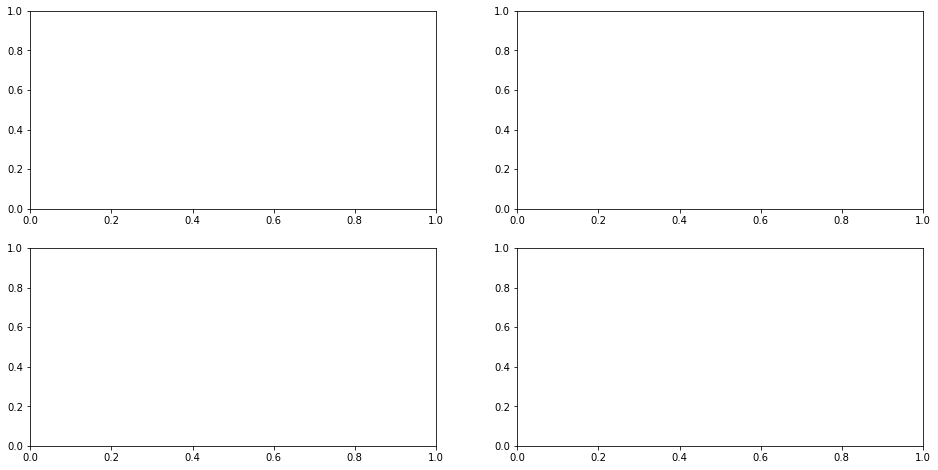

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
sns.kdeplot(data['Word Frequency'], hue = data['President'], fill=True, ax = axes[0,0])
sns.kdeplot(data['Named Years'], hue = data['President'], fill=True, ax = axes[0,1])
sns.kdeplot(data['Years from Wars'], hue = data['President'], fill=True, ax = axes[1,0])
sns.kdeplot(data['Positivity Score'], hue = data['President'], fill=True, ax = axes[1,1])

It appears that there is a significant difference between how George Washington and Donald Trump speak, which is appropriate given their different personalities, the state of the English language at the time, and the political climate they lived in. It appears that Donald Trump is much more consistent with his tone and language than George Washington, who seems to have a greater variety. Additionally, it is interesting to note that Donald Trump does mention named years and years from wars, but Washington does not at all. Due to these factors, it seems like it would be easy to distinguish the two.

This cell will save the data frame as a csv. That way, after we have saved it the first time, we won't have to re-run all of the cells involved in creating the data frame every time we start a new kernel.

In [13]:
data

,Date,President,Party,Speech Title,Summary,Transcript,URL,Word Frequency,Named Years,Years from Wars,...,Word PCA 0,Word PCA 1,Word PCA 2,Word PCA 3,Word PCA 4,Word PCA 5,Word PCA 6,Word PCA 7,Word PCA 8,Word PCA 9
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,0.090491,NaN,NaN,...,-0.551413,0.246995,-0.522495,-0.127006,0.078559,0.073576,-0.229439,-0.111018,-0.129139,0.805610
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...,0.166667,NaN,NaN,...,-0.971030,-0.503747,-0.067561,0.040960,0.373864,0.468999,-0.298893,0.136948,0.254910,0.115399
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,0.088608,NaN,NaN,...,-0.767471,-0.041545,-0.334048,-0.016243,0.227567,0.043845,-0.184359,-0.210881,0.221401,0.076085
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,0.087025,NaN,NaN,...,-0.516837,0.326462,-0.407628,-0.126410,0.241032,-0.280753,0.136927,-0.332647,0.445380,-0.124905
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...,0.187107,NaN,NaN,...,-0.517801,0.006876,-0.576012,0.451815,-0.212408,-0.458162,0.159091,-0.009281,-0.708990,-0.400286
5,1791-10-25,George Washington,Unaffiliated,Third Annual Message to Congress,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...,0.101808,NaN,NaN,...,-0.005079,1.292003,-0.721741,-0.223613,-0.209741,-1.253956,1.017685,-0.035944,-0.331295,-0.928231
6,1792-04-05,George Washington,Unaffiliated,Veto Message on Congressional Redistricting,President Washington returns a congressional r...,Gentlemen of the House of Representatives: I h...,https://millercenter.org/the-presidency/presid...,0.400000,NaN,NaN,...,-1.124821,-0.556953,-0.324080,-0.241615,0.278413,0.146353,-0.212012,-0.019453,0.105912,0.393950
7,1792-11-06,George Washington,Unaffiliated,Fourth Annual Message to Congress,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...,0.079670,NaN,NaN,...,-0.028762,1.149607,-0.652003,-0.352716,0.166769,-1.010906,0.511193,-0.491291,-0.522138,-0.514177
8,1792-12-12,George Washington,Unaffiliated,Proclamation Against Crimes Against the Cherok...,Offering a reward for the capture of American ...,"Whereas I have received authentic information,...",https://millercenter.org/the-presidency/presid...,0.212121,NaN,NaN,...,-1.108365,-0.567845,-0.304681,-0.204442,0.293846,0.222677,-0.248996,0.050210,0.064564,0.269257
9,1793-03-04,George Washington,Unaffiliated,Second Inaugural Address,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...,0.213115,NaN,NaN,...,-1.140945,-0.583351,-0.370303,-0.258509,0.333051,0.176213,-0.341304,-0.086437,0.168610,0.421576


In [14]:
data.to_csv('features_df.csv')

# Machine Learning using Dataframe 

In [15]:
data = pd.read_csv('features_df.csv',index_col=0) # Reloads the data frame from the csv
data.head() 

,Date,President,Party,Speech Title,Summary,Transcript,URL,Word Frequency,Named Years,Years from Wars,...,Word PCA 0,Word PCA 1,Word PCA 2,Word PCA 3,Word PCA 4,Word PCA 5,Word PCA 6,Word PCA 7,Word PCA 8,Word PCA 9
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,0.090491,NaN,NaN,...,-0.551413,0.246995,-0.522495,-0.127006,0.078559,0.073576,-0.229439,-0.111018,-0.129139,0.805610
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...,0.166667,NaN,NaN,...,-0.971030,-0.503747,-0.067561,0.040960,0.373864,0.468999,-0.298893,0.136948,0.254910,0.115399
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,0.088608,NaN,NaN,...,-0.767471,-0.041545,-0.334048,-0.016243,0.227567,0.043845,-0.184359,-0.210881,0.221401,0.076085
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,0.087025,NaN,NaN,...,-0.516837,0.326462,-0.407628,-0.126410,0.241032,-0.280753,0.136927,-0.332647,0.445380,-0.124905
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...,0.187107,NaN,NaN,...,-0.517801,0.006876,-0.576012,0.451815,-0.212408,-0.458162,0.159091,-0.009281,-0.708990,-0.400286


## SVM

### Imputing the Data

To make things simpler, we delete all non-numerical columns and change the Presidential labels to numbers.

These functions will be used to reclassify some columns of the dataframe.

In [16]:
# Numerically classify presidents
def reclassify_labels(data):
    presidents_to_classify = pd.unique(data['President'])
    
    # The exact value of the president will vary based on how many presidents we are trying to classify.
    for p in range(0, len(presidents_to_classify)):
        for i in range(0, len(data['President'])):
            if data['President'][i] == presidents_to_classify[p]:
                data['President'][i] = p
    return data

In [17]:
# Normalizing standardizes the data so all features are between -1 and 1.
def normalize(data):
    
    for column in data:
        if column != 'President': #We don't want to reclassify the presidential labels.
            data[column] = data[column]/(data[column].max())
    
    return data

In [18]:
pres_data = data.drop(columns = ['Date', 'Party', 'Speech Title', 'Summary', 'Transcript', 'URL'], axis = 1)

Replace any missing data with the column means.

In [19]:
pres_data['Named Years'].fillna(value=pres_data['Named Years'].mean(), inplace=True)
pres_data['Years from Wars'].fillna(value=pres_data['Years from Wars'].mean(), inplace=True)

Using the functions from above, we normalize the data and numerically classify the Presidents.

In [20]:
pres_data = normalize(pres_data)
pres_data = reclassify_labels(pres_data)

<ipython-input-16-8fad96c79c87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['President'][i] = p


### Separate the Features from the Labels

In [55]:
features = pres_data.drop(columns = 'President')
labels = pres_data['President'].astype(int)
features.head()

,Word Frequency,Named Years,Years from Wars,Positivity Score,Sentence Length,Word Length,Syllables per word,Stop Word Proportion,No. of Words,No. of Sentences,...,Word PCA 0,Word PCA 1,Word PCA 2,Word PCA 3,Word PCA 4,Word PCA 5,Word PCA 6,Word PCA 7,Word PCA 8,Word PCA 9
0,0.226227,0.995087,0.986486,0.791667,0.156414,0.949739,0.963421,0.974121,0.157686,0.030496,...,-0.218084,0.080634,-0.209100,-0.032435,0.020651,0.027377,-0.051669,-0.026287,-0.048861,0.220965
1,0.416667,0.995087,0.986486,1.000000,0.284686,0.912893,0.924069,0.945692,0.047834,0.005083,...,-0.384043,-0.164453,-0.027038,0.010460,0.098278,0.174508,-0.067309,0.032427,0.096448,0.031652
2,0.221519,0.995087,0.986486,0.904762,0.105709,0.985286,1.000000,0.955462,0.093248,0.026684,...,-0.303535,-0.013563,-0.133684,-0.004148,0.059821,0.016314,-0.041517,-0.049934,0.083770,0.020869
3,0.217563,0.995087,0.986486,0.700000,0.091688,0.940159,0.928386,0.981746,0.154058,0.050826,...,-0.204409,0.106577,-0.163131,-0.032283,0.063360,-0.104465,0.030835,-0.078766,0.168514,-0.034259
4,0.467767,0.995087,0.986486,0.680000,0.076462,0.867136,0.839041,0.975943,0.154168,0.060991,...,-0.204791,0.002245,-0.230517,0.115386,-0.055836,-0.170476,0.035827,-0.002198,-0.268254,-0.109792


### Split the Data into Test and Training Sets

Initially, the training set is set to be 75% of the data.

In [56]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size = 0.75, random_state = 0)

### Finding the Best Parameters for Model Using Grid Search

In [58]:
param_grid = {'kernel':('linear', 'rbf'),
              'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [1e-3, 1e-2, 1e-1, 1, 10]}
clf = GridSearchCV(SVC(probability = True), param_grid)

clf = clf.fit(train_features, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1, gamma=0.001, kernel='linear', probability=True)


### Judging the Accuracy of the Model

In [59]:
pred_labels = clf.predict(test_features) #Running the model on the testing data
# Getting the confusion matrix and classification report
conf_mat = confusion_matrix(test_labels, pred_labels)
class_rep = classification_report(test_labels, pred_labels)
#formatting the confusion matrix and classification report:
# First, we want to replace the numerical labels in the class rep with the names of presidents. The extra space at
#the end prevents actual numerical data from being replaced by a president's name.
preslist = ['Washington ','Trump '] 
# We need to replace a number of 0's equal to 1 less than the length of the president's name before the number so 
#that everything is still aligned properly
replacelist = [' '*(len(preslist[i])-2)+f'{i} ' for i in range(len(preslist))]
class_rep = mreplace(class_rep,replacelist,preslist,max=1) #replace all the substrings in replacelist with preslist
#The confusion matrix will be turned into a DF with a multi-index so that it is easy to tell what each row and col
#represent.
cols = pd.MultiIndex.from_product([['Predicted Speaker'],preslist])
rows = pd.MultiIndex.from_product([['Actual Speaker'],preslist])
print(class_rep)
pd.DataFrame(conf_mat,index=rows,columns=cols)

              precision    recall  f1-score   support

  Washington       1.00      0.83      0.91         6
       Trump       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



Predicted Speaker       
                                 Washington  Trump 
Actual Speaker Washington                  5      1
               Trump                       0      4

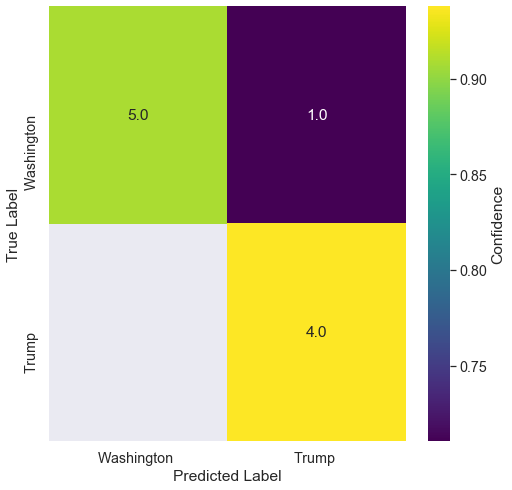

In [60]:
confusion_image(clf,test_features,test_labels,preslist)

# Adding Another President to Model

## Reading in Data and Adding Features to Dataset

In [26]:
FDR_data = orig_data[orig_data['President'] == 'Franklin D. Roosevelt']
FDR_data = FDR_data.reset_index(drop = True)
FDR_data.tail()

,Date,President,Party,Speech Title,Summary,Transcript,URL
44,1944-06-12,Franklin D. Roosevelt,Democratic,Opening Fifth War Loan Drive,"Less than a week after D-Day, Roosevelt calls ...",Ladies and Gentlemen: All our fighting men ove...,https://millercenter.org/the-presidency/presid...
45,1944-07-20,Franklin D. Roosevelt,Democratic,Democratic National Convention,President Roosevelt accepts the Democratic Par...,I have already indicated to you why I accept t...,https://millercenter.org/the-presidency/presid...
46,1945-01-20,Franklin D. Roosevelt,Democratic,Fourth Inaugural Address,Franklin Delano Roosevelt makes a brief addres...,"Mr. Chief Justice, Mr. Vice President, my frie...",https://millercenter.org/the-presidency/presid...
47,1945-02-11,Franklin D. Roosevelt,Democratic,Joint Statement with Churchill and Stalin on t...,NaN,THE DEFEAT OF GERMANY We have considered and d...,https://millercenter.org/the-presidency/presid...
48,1945-03-01,Franklin D. Roosevelt,Democratic,Address to Congress on Yalta,President Roosevelt reports on his meeting wit...,I hope that you will pardon me for this unusua...,https://millercenter.org/the-presidency/presid...


We are using the same functions that we used before so that this FDR dataset contains all the same features as the original.

In [27]:
FDR_data['Word Frequency'] = word_frequency(FDR_data, n = 10, remove_stopwords = True)
FDR_data['Named Years'] = named_years(FDR_data)
FDR_data['Years from Wars'] = year_from_wars(FDR_data)

In [28]:
classifier = build_sentiment_model()
FDR_data['Positivity Score'] = [positivity_score(x, classifier) for x in FDR_data['Transcript']]

In [29]:
FDR_data['Sentence Length'] = sentlen(FDR_data['Transcript'])
FDR_data['Word Length'] = wordlen(FDR_data['Transcript'])
FDR_data['Syllables per word'] = avesylls(FDR_data['Transcript'])
FDR_data['Stop Word Proportion'] = SWprop(FDR_data['Transcript'])
FDR_data['No. of Words'] = wordcount(FDR_data['Transcript'])
FDR_data['No. of Sentences'] = sentcount(FDR_data['Transcript'])

In [30]:
FDR_data['Reading Level'] = readlvl(FDR_data['Transcript'])

In [31]:
# Once again, this cell takes a while to run.
FDR_data_PCA = FDR_data[['President', 'Transcript']]
PCAfeatures = PCAphrases(FDR_data_PCA, n = 1, numfeatures = 10)
PCAfeatures.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.653270,-0.098564,-0.181291,-0.069400,-0.676555,0.229095,0.090641,0.628187,0.219250,0.670334
1,-0.701714,-0.714267,0.692536,0.519886,0.724055,0.661530,-0.680213,-0.374731,-1.089295,0.543360
2,0.288454,-0.417468,-0.051238,-1.546626,0.481795,-0.890704,0.449473,0.686012,-1.557381,-1.124549
3,0.122642,-0.239111,0.770108,-0.875180,0.819181,0.209052,-0.256888,0.001327,-0.345346,-0.299996
4,-0.031843,-0.787846,0.503815,-0.745919,0.586397,0.392709,-1.472166,0.049263,-1.043633,0.099833


In [32]:
for i in range(10):
    FDR_data[f'Word PCA {i}'] = PCAfeatures[i]

In [33]:
FDR_data.head()

,Date,President,Party,Speech Title,Summary,Transcript,URL,Word Frequency,Named Years,Years from Wars,...,Word PCA 0,Word PCA 1,Word PCA 2,Word PCA 3,Word PCA 4,Word PCA 5,Word PCA 6,Word PCA 7,Word PCA 8,Word PCA 9
0,1933-03-04,Franklin D. Roosevelt,Democratic,First Inaugural Address,President Franklin Delano Roosevelt delivers t...,"President Hoover, Mr. Chief Justice, my friend...",https://millercenter.org/the-presidency/presid...,0.080000,NaN,NaN,...,-0.653270,-0.098564,-0.181291,-0.069400,-0.676555,0.229095,0.090641,0.628187,0.219250,0.670334
1,1933-03-12,Franklin D. Roosevelt,Democratic,On the Banking Crisis,"By the time of Roosevelt's inauguration, nearl...",I want to talk for a few minutes with the peop...,https://millercenter.org/the-presidency/presid...,0.156404,NaN,NaN,...,-0.701714,-0.714267,0.692536,0.519886,0.724055,0.661530,-0.680213,-0.374731,-1.089295,0.543360
2,1933-05-07,Franklin D. Roosevelt,Democratic,On Progress During the First Two Months,"Sixty days into the ""First Hundred Days"" Roose...",On a Sunday night a week after my Inauguration...,https://millercenter.org/the-presidency/presid...,0.082985,NaN,NaN,...,0.288454,-0.417468,-0.051238,-1.546626,0.481795,-0.890704,0.449473,0.686012,-1.557381,-1.124549
3,1933-07-24,Franklin D. Roosevelt,Democratic,On the National Recovery Administration,Roosevelt defends the New Deal at the end of t...,After the adjournment of the historical specia...,https://millercenter.org/the-presidency/presid...,0.091231,NaN,NaN,...,0.122642,-0.239111,0.770108,-0.875180,0.819181,0.209052,-0.256888,0.001327,-0.345346,-0.299996
4,1933-10-22,Franklin D. Roosevelt,Democratic,On Economic Progress,In the midst of discouraging economic news rep...,It is three months since I have talked with th...,https://millercenter.org/the-presidency/presid...,0.100230,0.956931,NaN,...,-0.031843,-0.787846,0.503815,-0.745919,0.586397,0.392709,-1.472166,0.049263,-1.043633,0.099833


In [34]:
FDR_data.to_csv('FDR_features_df.csv')

### Imputing FDR Data

After combining data from FDR with that of the other presidents, we'll normalize the data, numerically categorize the presidents, and fill in any missing values using the same methods as we did above.

In [35]:
FDR_data = pd.read_csv('FDR_features_df.csv',index_col=0) # Reloads the data frame from the csv

In [36]:
full_data = pd.concat([pres_data, FDR_data], ignore_index = True)

In [37]:
full_data = full_data.drop(columns = ['Date', 'Party', 'Speech Title', 'Summary', 'Transcript', 'URL'], axis = 1)

In [38]:
axes[0,0].legend

<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x000001FB6E476550>>

Once again, let's visualize the data before we impute it. Once again, all three presidents are fairly distinct from each other.

AttributeError: 'Line2D' object has no property 'hue'

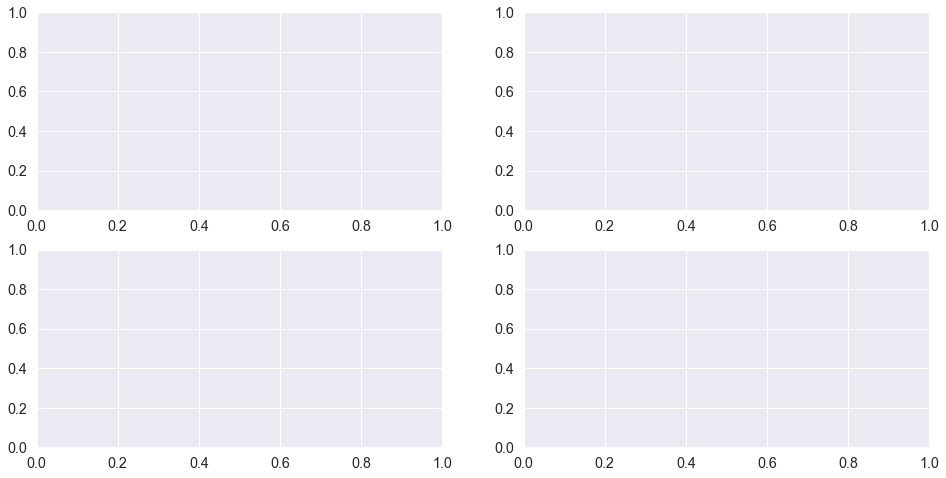

In [39]:
label_legend_data = pd.concat([data['President'],FDR_data['President']], ignore_index = True)
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
sns.kdeplot(full_data['Word Frequency'], hue = label_legend_data, fill=True, ax = axes[0,0])
sns.kdeplot(full_data['Named Years'], hue = label_legend_data, fill=True, ax = axes[0,1])
sns.kdeplot(full_data['Years from Wars'], hue = label_legend_data, fill=True, ax = axes[1,0])
sns.kdeplot(full_data['Positivity Score'], hue = label_legend_data, fill=True, ax = axes[1,1])

In [40]:
full_data['Named Years'].fillna(value=full_data['Named Years'].mean(), inplace=True)
full_data['Years from Wars'].fillna(value=full_data['Years from Wars'].mean(), inplace=True)

In [41]:
full_data = normalize(full_data)
full_data = reclassify_labels(full_data)

<ipython-input-16-8fad96c79c87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['President'][i] = p


In [42]:
full_data

,President,Word Frequency,Named Years,Years from Wars,Positivity Score,Sentence Length,Word Length,Syllables per word,Stop Word Proportion,No. of Words,...,Word PCA 0,Word PCA 1,Word PCA 2,Word PCA 3,Word PCA 4,Word PCA 5,Word PCA 6,Word PCA 7,Word PCA 8,Word PCA 9
0,0,0.226227,0.995087,0.986486,0.791667,0.004757,0.185863,0.593942,0.974121,0.000026,...,-0.075251,0.028343,-0.057066,-0.011986,0.006312,0.011409,-0.020771,-0.011428,-0.024184,0.091759
1,0,0.416667,0.995087,0.986486,1.000000,0.008659,0.178652,0.569682,0.945692,0.000008,...,-0.132515,-0.057805,-0.007379,0.003865,0.030039,0.072726,-0.027059,0.014097,0.047738,0.013144
2,0,0.221519,0.995087,0.986486,0.904762,0.003215,0.192819,0.616493,0.955462,0.000015,...,-0.104736,-0.004767,-0.036484,-0.001533,0.018284,0.006799,-0.016690,-0.021707,0.041462,0.008666
3,0,0.217563,0.995087,0.986486,0.700000,0.002789,0.183988,0.572344,0.981746,0.000026,...,-0.070532,0.037462,-0.044521,-0.011929,0.019366,-0.043535,0.012396,-0.034241,0.083407,-0.014227
4,0,0.467767,0.995087,0.986486,0.680000,0.002326,0.169697,0.517263,0.975943,0.000026,...,-0.070664,0.000789,-0.062911,0.042638,-0.017066,-0.071046,0.014403,-0.000955,-0.132774,-0.045593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2,0.112346,0.960726,0.977145,0.512821,0.640665,0.886540,0.863390,0.506999,0.272335,...,-0.303361,0.279811,0.078546,0.285038,0.147908,-0.332010,-0.134139,0.021494,0.210261,-0.295845
85,2,0.112455,0.959406,0.977145,0.514706,0.793474,0.890021,0.877477,0.532694,0.294049,...,-0.227695,0.206572,0.196543,0.000595,0.175651,-0.222081,0.064696,-0.130095,-0.354992,-0.014702
86,2,0.152941,0.884653,0.977145,0.458333,0.656262,0.825702,0.801111,0.543672,0.092989,...,-0.614493,0.161666,0.129621,0.064843,-0.049275,0.129904,0.269775,0.355886,-0.037086,0.011821
87,2,0.146056,0.974857,0.977145,0.587302,0.912904,1.000000,1.000000,0.489309,0.333333,...,-0.106033,-0.050467,0.046527,0.490778,-0.088316,-0.529961,-0.121702,0.223442,-0.305512,0.034018


### Separate the Features from the Labels

In [61]:
features = full_data.drop(columns = 'President')
labels = full_data['President'].astype(int)
features.head()

,Word Frequency,Named Years,Years from Wars,Positivity Score,Sentence Length,Word Length,Syllables per word,Stop Word Proportion,No. of Words,No. of Sentences,...,Word PCA 0,Word PCA 1,Word PCA 2,Word PCA 3,Word PCA 4,Word PCA 5,Word PCA 6,Word PCA 7,Word PCA 8,Word PCA 9
0,0.226227,0.995087,0.986486,0.791667,0.004757,0.185863,0.593942,0.974121,0.000026,0.000116,...,-0.075251,0.028343,-0.057066,-0.011986,0.006312,0.011409,-0.020771,-0.011428,-0.024184,0.091759
1,0.416667,0.995087,0.986486,1.000000,0.008659,0.178652,0.569682,0.945692,0.000008,0.000019,...,-0.132515,-0.057805,-0.007379,0.003865,0.030039,0.072726,-0.027059,0.014097,0.047738,0.013144
2,0.221519,0.995087,0.986486,0.904762,0.003215,0.192819,0.616493,0.955462,0.000015,0.000101,...,-0.104736,-0.004767,-0.036484,-0.001533,0.018284,0.006799,-0.016690,-0.021707,0.041462,0.008666
3,0.217563,0.995087,0.986486,0.700000,0.002789,0.183988,0.572344,0.981746,0.000026,0.000193,...,-0.070532,0.037462,-0.044521,-0.011929,0.019366,-0.043535,0.012396,-0.034241,0.083407,-0.014227
4,0.467767,0.995087,0.986486,0.680000,0.002326,0.169697,0.517263,0.975943,0.000026,0.000231,...,-0.070664,0.000789,-0.062911,0.042638,-0.017066,-0.071046,0.014403,-0.000955,-0.132774,-0.045593


### Split the Data into Testing and Training Sets

In [62]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size = 0.75, random_state = 0)

### Pass Full Data to Model

Using the same classifiers that we found above, we can re-fit the model to the new data and test it.

In [63]:
clf = clf.fit(train_features, train_labels)

In [64]:
pred_labels = clf.predict(test_features)
# Once again, creating a confusion matrix and classification report
conf_mat = confusion_matrix(test_labels, pred_labels)
class_rep = classification_report(test_labels, pred_labels)
# Formatting the confusion matrixCand classification report in the same way as before
preslist = ['Washington ','Trump ','Roosevelt ']
replacelist = [' '*(len(preslist[i])-2)+f'{i} ' for i in range(len(preslist))]
class_rep = mreplace(class_rep,replacelist,preslist,max=1)
cols = pd.MultiIndex.from_product([['Predicted Speaker'],preslist])
rows = pd.MultiIndex.from_product([['Actual Speaker'],preslist])
print(class_rep)
pd.DataFrame(conf_mat,index=rows,columns=cols)

              precision    recall  f1-score   support

  Washington       0.86      1.00      0.92         6
       Trump       1.00      0.80      0.89         5
   Roosevelt       1.00      1.00      1.00        12

    accuracy                           0.96        23
   macro avg       0.95      0.93      0.94        23
weighted avg       0.96      0.96      0.96        23



Predicted Speaker                  
                                 Washington  Trump  Roosevelt 
Actual Speaker Washington                  6      0          0
               Trump                       1      4          0
               Roosevelt                   0      0         12

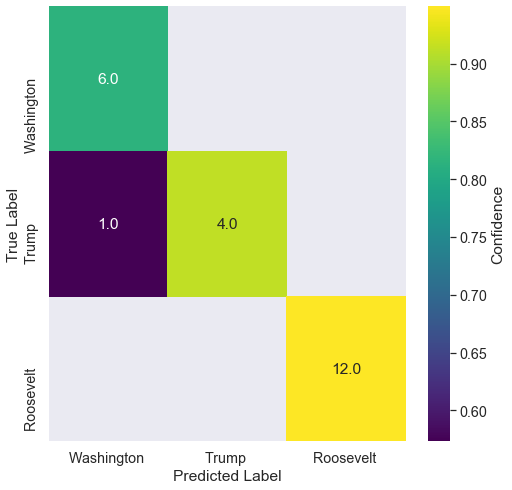

In [65]:
confusion_image(clf,test_features,test_labels,preslist)

In [ ]:
# Find repository of random presidential speeches and send through model?

In [ ]:
# Beautify notebook (confusion matrix)
# Add graphs
# Correlation matrix
# Annotate notebook